In [20]:
from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose




# URL of the dataset
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=ICSA"

# Fetching the data from the URL
response = requests.get(url)

# Reading the data into a DataFrame
df = pd.read_csv(io.StringIO(response.text))

print(df.head(10))  # Displays the first 10 rows



         DATE    ICSA
0  1967-01-07  208000
1  1967-01-14  207000
2  1967-01-21  217000
3  1967-01-28  204000
4  1967-02-04  216000
5  1967-02-11  229000
6  1967-02-18  229000
7  1967-02-25  242000
8  1967-03-04  310000
9  1967-03-11  241000


In [21]:
df.shape

(2983, 2)

In [22]:
# Convert 'DATE' column to datetime
print('DATE data type before conversion:')
print(df['DATE'].dtypes)
df['DATE'] = pd.to_datetime(df['DATE'])
print('DATE data type after conversion:')
print(df['DATE'].dtypes)

DATE data type before conversion:
object
DATE data type after conversion:
datetime64[ns]


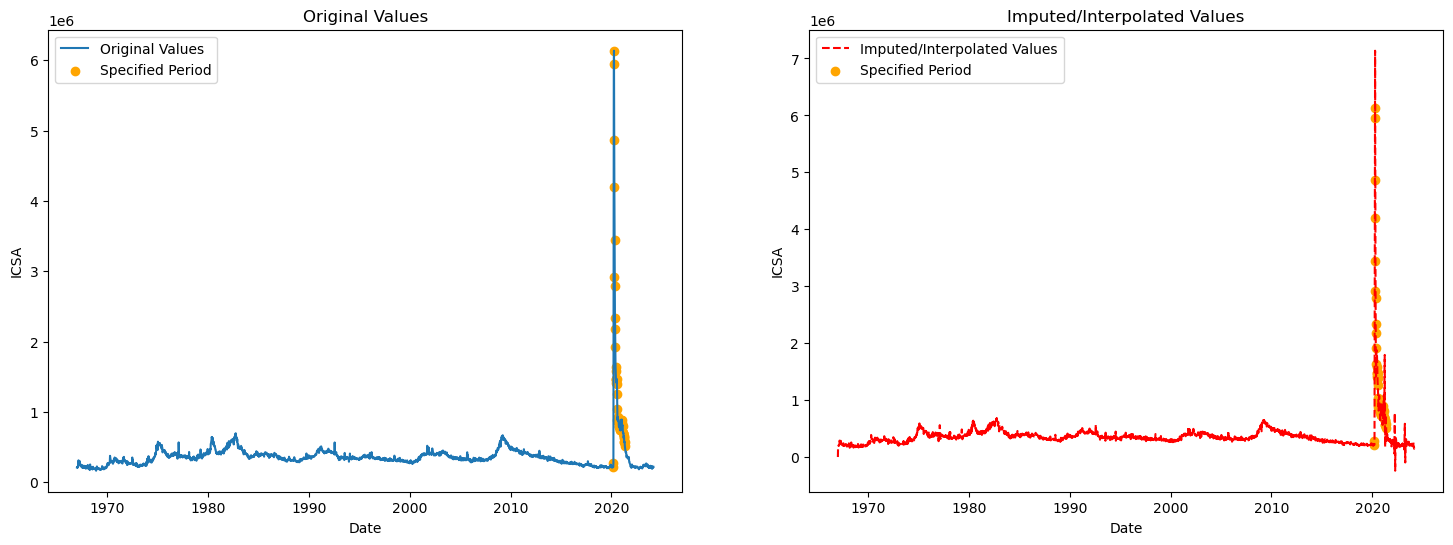

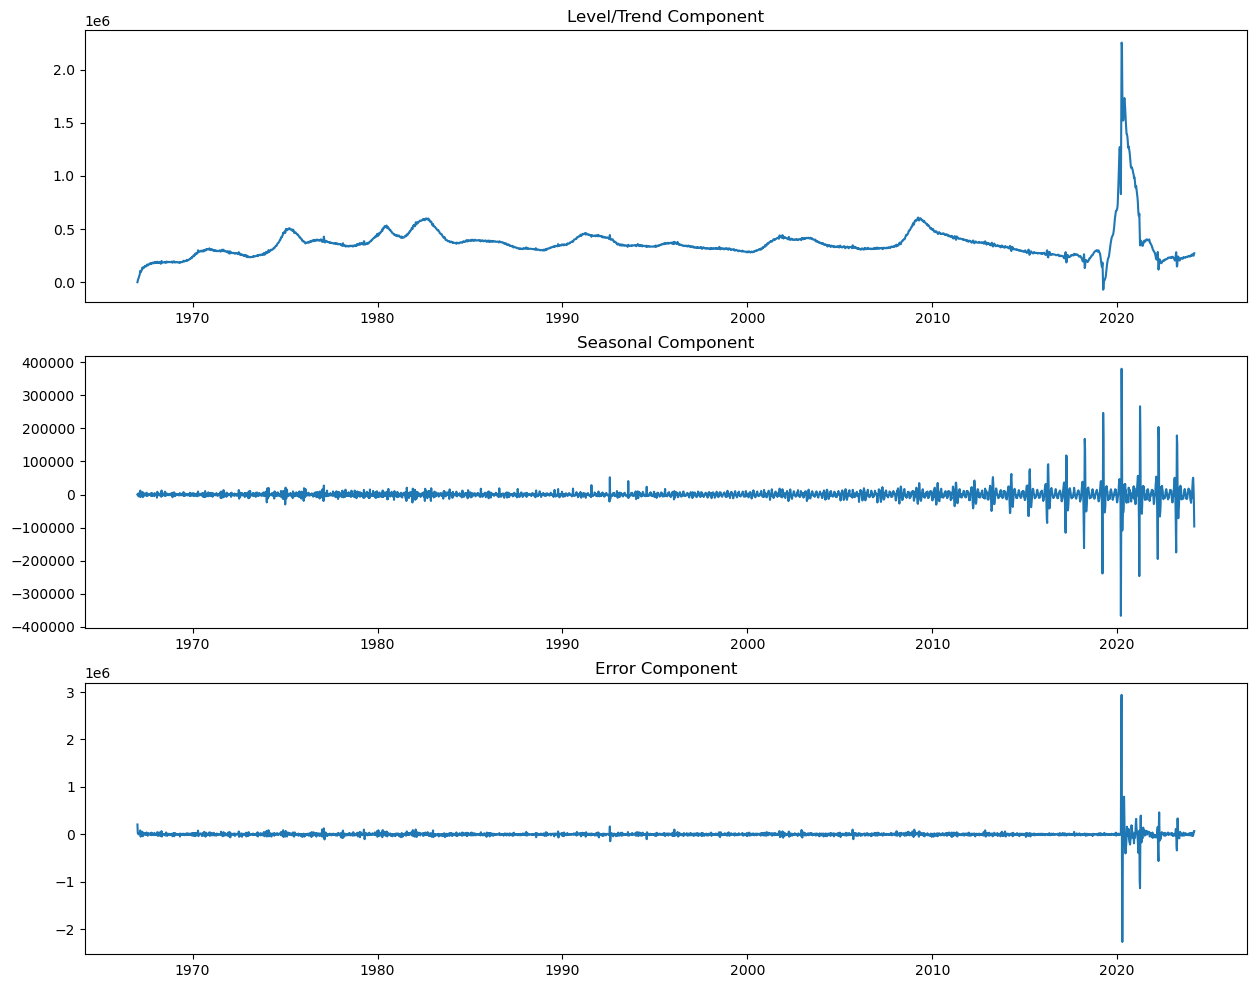

In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.structural import UnobservedComponents
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and already loaded
start_date = '2020-03-01'
end_date = '2021-05-01'
period_data = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

results = UnobservedComponents(df['ICSA'],level='llevel',seasonal=52,freq_seasonal=[{'period': 52, 'harmonics': 4}], autoregressive=1).fit()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# Impute the missing values using the predict method
df['ICSA_imputed'] = results.predict()

axs[0].plot(df['DATE'], df['ICSA'], label='Original Values')
axs[0].scatter(period_data['DATE'], period_data['ICSA'], color='orange', label='Specified Period')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('ICSA')
axs[0].set_title('Original Values')
axs[0].legend()


axs[1].plot(df['DATE'], df['ICSA_imputed'], label='Imputed/Interpolated Values', linestyle='--', color='red')
axs[1].scatter(period_data['DATE'], period_data['ICSA'], color='orange', label='Specified Period')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('ICSA')
axs[1].set_title('Imputed/Interpolated Values')
axs[1].legend()

plt.show()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))
# Level/Trend
axes[0].plot(df['DATE'], results.level.smoothed, label='Level/Trend')
axes[0].set_title('Level/Trend Component')

# Seasonal
axes[1].plot(df['DATE'], results.seasonal.smoothed, label='Seasonal')
axes[1].set_title('Seasonal Component')

# Error
axes[2].plot(df['DATE'], results.resid, label='Error')
axes[2].set_title('Error Component')

plt.show()

In [26]:
url1 = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=CCSA"

# Fetching the data from the URL
response = requests.get(url1)

# Reading the data into a DataFrame
df1 = pd.read_csv(io.StringIO(response.text))
print(df1.head(10))

         DATE     CCSA
0  1967-01-07  1134000
1  1967-01-14  1119000
2  1967-01-21  1119000
3  1967-01-28  1103000
4  1967-02-04  1131000
5  1967-02-11  1153000
6  1967-02-18  1167000
7  1967-02-25  1199000
8  1967-03-04  1235000
9  1967-03-11  1234000


In [27]:
# Convert 'DATE' column to datetime
print('DATE data type before conversion:')
print(df1['DATE'].dtypes)
df1['DATE'] = pd.to_datetime(df1['DATE'])
print('DATE data type after conversion:')
print(df1['DATE'].dtypes)

DATE data type before conversion:
object
DATE data type after conversion:
datetime64[ns]


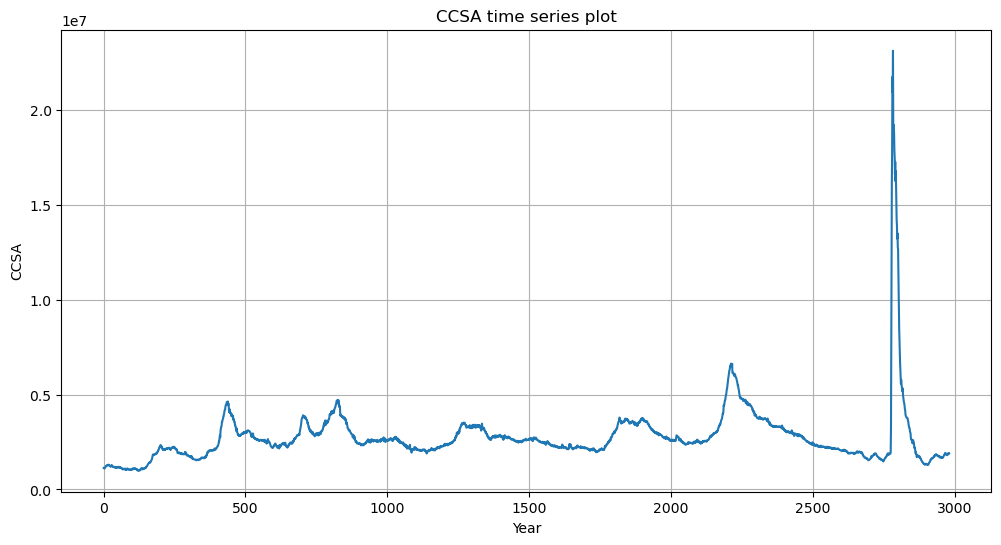

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df1.index, df1['CCSA'])
plt.title('CCSA time series plot')
plt.xlabel('Year')
plt.ylabel('CCSA')
plt.grid(True)
plt.show()

In [29]:
monthly_df = df.resample('M', on='DATE').mean()

# Reset the index to turn the time index into a column
monthly_df = monthly_df.reset_index()
monthly_df['DATE'] = monthly_df['DATE'] + pd.offsets.MonthEnd(0)
df1['DATE'] = df1['DATE'] + pd.offsets.MonthEnd(0)

#merging the DataFrames on the 'time' column
merged_df = pd.merge(monthly_df, df1, on='DATE', how='inner')
print(merged_df.head(10))

        DATE      ICSA   ICSA_imputed     CCSA
0 1967-01-31  209000.0  144938.820843  1134000
1 1967-01-31  209000.0  144938.820843  1119000
2 1967-01-31  209000.0  144938.820843  1119000
3 1967-01-31  209000.0  144938.820843  1103000
4 1967-02-28  229000.0  206952.631413  1131000
5 1967-02-28  229000.0  206952.631413  1153000
6 1967-02-28  229000.0  206952.631413  1167000
7 1967-02-28  229000.0  206952.631413  1199000
8 1967-03-31  260750.0  245153.974462  1235000
9 1967-03-31  260750.0  245153.974462  1234000


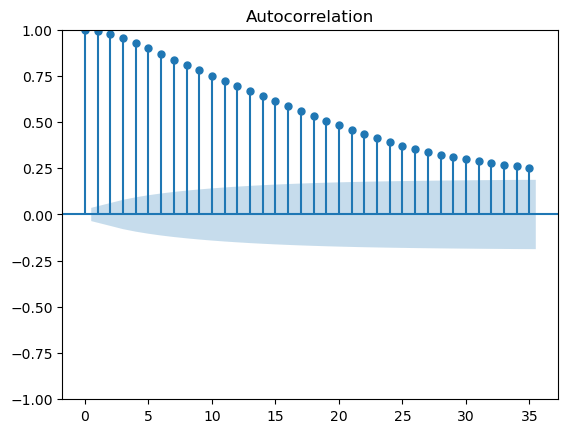

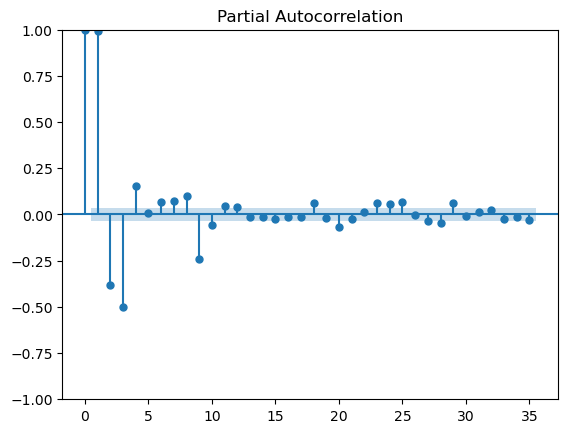

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_df['CCSA'].dropna())
plot_pacf(merged_df['CCSA'].dropna())
plt.show()

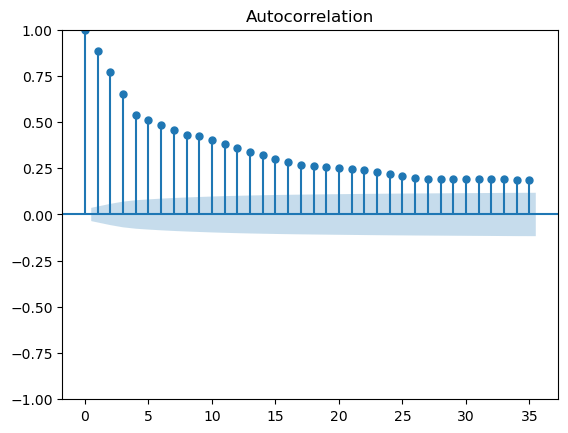

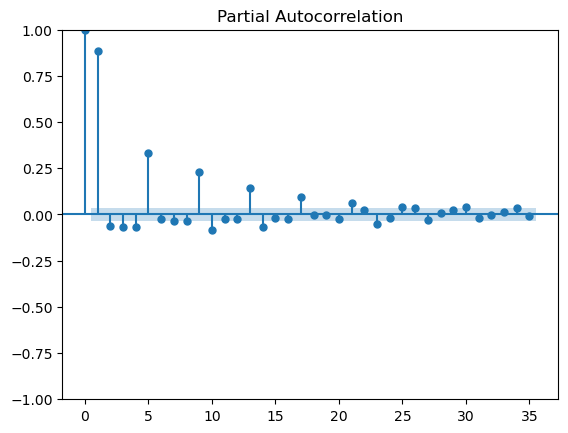

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_df['ICSA_imputed'].dropna())
plot_pacf(merged_df['ICSA_imputed'].dropna())
plt.show()

In [32]:
from sklearn.model_selection import train_test_split

X = merged_df[['CCSA']]
y = merged_df['ICSA_imputed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from pmdarima import auto_arima

arima_model = auto_arima(y_train, exogenous=X_train, seasonal=True, suppress_warnings=True)
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2385
Model:                        SARIMAX   Log Likelihood              -32845.080
Date:                Thu, 07 Mar 2024   AIC                          65694.160
Time:                        12:48:51   BIC                          65705.714
Sample:                             0   HQIC                         65698.365
                               - 2385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.642e+05   8913.520     40.862      0.000    3.47e+05    3.82e+05
sigma2      5.362e+10   2.29e+08    234.642      0.000    5.32e+10    5.41e+10
Ljung-Box (L1) (Q):                   0.43   Jarque-

In [34]:
forecast, conf_int = arima_model.predict(n_periods=len(y_test), exogenous=X_test, return_conf_int=True)
forecast_df = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_test.values,
    'Forecast': forecast,
    'Lower_CI': conf_int[:, 0],
    'Upper_CI': conf_int[:, 1]
})

print(forecast_df)

      Date         Actual       Forecast      Lower_CI       Upper_CI
2385  2409  344366.019652  364228.690773 -89615.696372  818073.077919
2386  1547  333410.355352  364228.690773 -89615.696372  818073.077919
2387   881  397068.943311  364228.690773 -89615.696372  818073.077919
2388   331  244686.270938  364228.690773 -89615.696372  818073.077919
2389  2225  567200.182989  364228.690773 -89615.696372  818073.077919
...    ...            ...            ...           ...            ...
2977   999  383006.232306  364228.690773 -89615.696372  818073.077919
2978   422  540600.237327  364228.690773 -89615.696372  818073.077919
2979  1868  403603.548350  364228.690773 -89615.696372  818073.077919
2980  1429  356579.684749  364228.690773 -89615.696372  818073.077919
2981  2622  230309.121925  364228.690773 -89615.696372  818073.077919

[597 rows x 5 columns]


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [35]:
last_forecast_row = forecast_df.iloc[-1]

forecast_value = last_forecast_row['Forecast']
lower_ci = last_forecast_row['Lower_CI']
upper_ci = last_forecast_row['Upper_CI']

print(f"So I forecast the new data release value will be {forecast_value:.1f} with confidence interval ({lower_ci:.1f}, {upper_ci:.1f})")


So I forecast the new data release value will be 364228.7 with confidence interval (-89615.7, 818073.1)
